# Adverse Selection Detection via Logit Jump-Diffusion

**Implementation of Dalen (2025) RN-JD calibration on Kalshi KXTOPMONTHLY markets**

Reference: *Toward Black-Scholes for Prediction Markets* (arXiv:2510.15205)

---

### Structure
1. Data loading and train/test split
2. RN-JD calibration -- Rolling EM to extract belief-vol, jump intensity, gamma_t
3. Showcase -- AS detection visualised on the most liquid ticker
4. Belief-volatility surface
5. AS event characterisation
6. Fill toxicity validation (the key test)
7. Market-making backtest -- Naive vs AS-informed (tau=0.7)
8. Threshold sweep
9. Cross-ticker analysis
10. Summary


In [10]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats as sp_stats

from src.as_detector import run_as_detection, run_all_tickers, ASResult
from src.mm_backtest import (
    compare_strategies, compare_all_tickers,
    sweep_thresholds, backtest_mm, analyse_fill_toxicity,
)

plt.rcParams.update({"figure.figsize": (14, 5), "axes.grid": True, "grid.alpha": 0.3, "font.size": 11})

import glob
CACHE = os.path.join('..', 'cache', 'kalshi_hf')
all_files = sorted(glob.glob(os.path.join(CACHE, '*_trades.parquet')))
print(f"Found {len(all_files)} parquet files")

data = {}
for f in all_files:
    tkr = os.path.basename(f).replace("_trades.parquet", "")
    df = pd.read_parquet(f)
    if len(df) >= 250:
        data[tkr] = df

data = dict(sorted(data.items(), key=lambda x: -len(x[1])))
print(f"Loaded {len(data)} tickers with >= 250 trades")
print(f"Total trades: {sum(len(v) for v in data.values()):,}")
for tkr, df in data.items():
    print(f"  {tkr:<45s}  {len(df):>6,} trades  [{df['mid_price'].min():.2f} - {df['mid_price'].max():.2f}]")


Found 86 parquet files
Loaded 13 tickers with >= 250 trades
Total trades: 33,576
  KXTOPMONTHLY-26FEB-BAD                         11,077 trades  [0.03 - 0.76]
  KXTOPMONTHLY-26FEB-BRU                          5,381 trades  [0.32 - 0.96]
  KXTOPMONTHLY-26JAN-WEE                          3,517 trades  [0.01 - 0.93]
  KXTOPMONTHLY-25DEC-WEE                          2,474 trades  [0.01 - 0.84]
  KXTOPMONTHLY-26JAN-BRU                          2,170 trades  [0.02 - 0.99]
  KXTOPMONTHLY-26JAN-TAY                          2,052 trades  [0.01 - 0.99]
  KXTOPMONTHLY-26JAN-BAD                          1,791 trades  [0.01 - 0.08]
  KXTOPMONTHLY-26FEB-TAY                          1,331 trades  [0.01 - 0.64]
  KXTOPMONTHLY-26FEB-WEE                          1,227 trades  [0.01 - 0.10]
  KXTOPMONTHLY-26JAN-ARI                          1,212 trades  [0.01 - 0.24]
  KXTOPMONTHLY-25DEC-ARI                            599 trades  [0.05 - 0.99]
  KXTOPMONTHLY-25DEC-TAY                            459 trade

## 1. Train/Test Split

- **Train**: Oct 2025 - Jan 2026 (calibrate, tune)
- **Test**: Feb 2026 (out-of-sample backtest)


In [11]:
train_tickers = {k: v for k, v in data.items() if "26FEB" not in k}
test_tickers = {k: v for k, v in data.items() if "26FEB" in k}
print(f"Train: {len(train_tickers)} tickers, {sum(len(v) for v in train_tickers.values()):,} trades")
print(f"Test:  {len(test_tickers)} tickers, {sum(len(v) for v in test_tickers.values()):,} trades")


Train: 9 tickers, 14,560 trades
Test:  4 tickers, 19,016 trades


## 2. RN-JD Calibration (Dalen Sections 5.1-5.2)

1. Heteroskedastic Kalman filter on log-odds x_t
2. Rolling EM to separate diffusion from jumps
3. Extract gamma_t: posterior probability each trade was a jump


In [12]:
all_as = run_all_tickers(data, em_window=200, em_iterations=8)
print(f"Calibrated {len(all_as)} tickers")

cal_rows = [ar.calibration_summary for tkr, ar in sorted(all_as.items(), key=lambda x: -len(x[1].prices))]
cal_df = pd.DataFrame(cal_rows)
cols = ["ticker", "n_trades", "mean_sigma_b", "mean_lambda", "mean_s_j",
        "n_jumps_detected", "n_bursts_detected", "n_events_flagged", "pct_flagged"]
print("\nTable 1: Calibrated RN-JD Parameters")
print("=" * 120)
print(cal_df[cols].to_string(index=False, float_format="%.5f"))


[2026-02-25 00:46:02 UTC] [INFO] tauroi.as_detector — AS detection KXTOPMONTHLY-26FEB-BAD: 11077 trades, 1663 jumps (γ>0.5), 1484 bursts, 1461 flagged (score>0.5), mean σ_b=0.0005, mean λ=0.00178
[2026-02-25 00:46:03 UTC] [INFO] tauroi.as_detector — AS detection KXTOPMONTHLY-26FEB-BRU: 5381 trades, 1492 jumps (γ>0.5), 1382 bursts, 1411 flagged (score>0.5), mean σ_b=0.0001, mean λ=0.00137
[2026-02-25 00:46:03 UTC] [INFO] tauroi.as_detector — AS detection KXTOPMONTHLY-26JAN-WEE: 3517 trades, 2467 jumps (γ>0.5), 1007 bursts, 2441 flagged (score>0.5), mean σ_b=0.0001, mean λ=0.00204
[2026-02-25 00:46:04 UTC] [INFO] tauroi.as_detector — AS detection KXTOPMONTHLY-25DEC-WEE: 2474 trades, 2076 jumps (γ>0.5), 0 bursts, 2037 flagged (score>0.5), mean σ_b=0.0248, mean λ=0.00103
[2026-02-25 00:46:05 UTC] [INFO] tauroi.as_detector — AS detection KXTOPMONTHLY-26JAN-BRU: 2170 trades, 431 jumps (γ>0.5), 259 bursts, 393 flagged (score>0.5), mean σ_b=0.0001, mean λ=0.00027
[2026-02-25 00:46:05 UTC] [INF

## 3. Showcase: AS Detection on Most Liquid Ticker


Showcase: KXTOPMONTHLY-26FEB-BAD (11,077 trades)


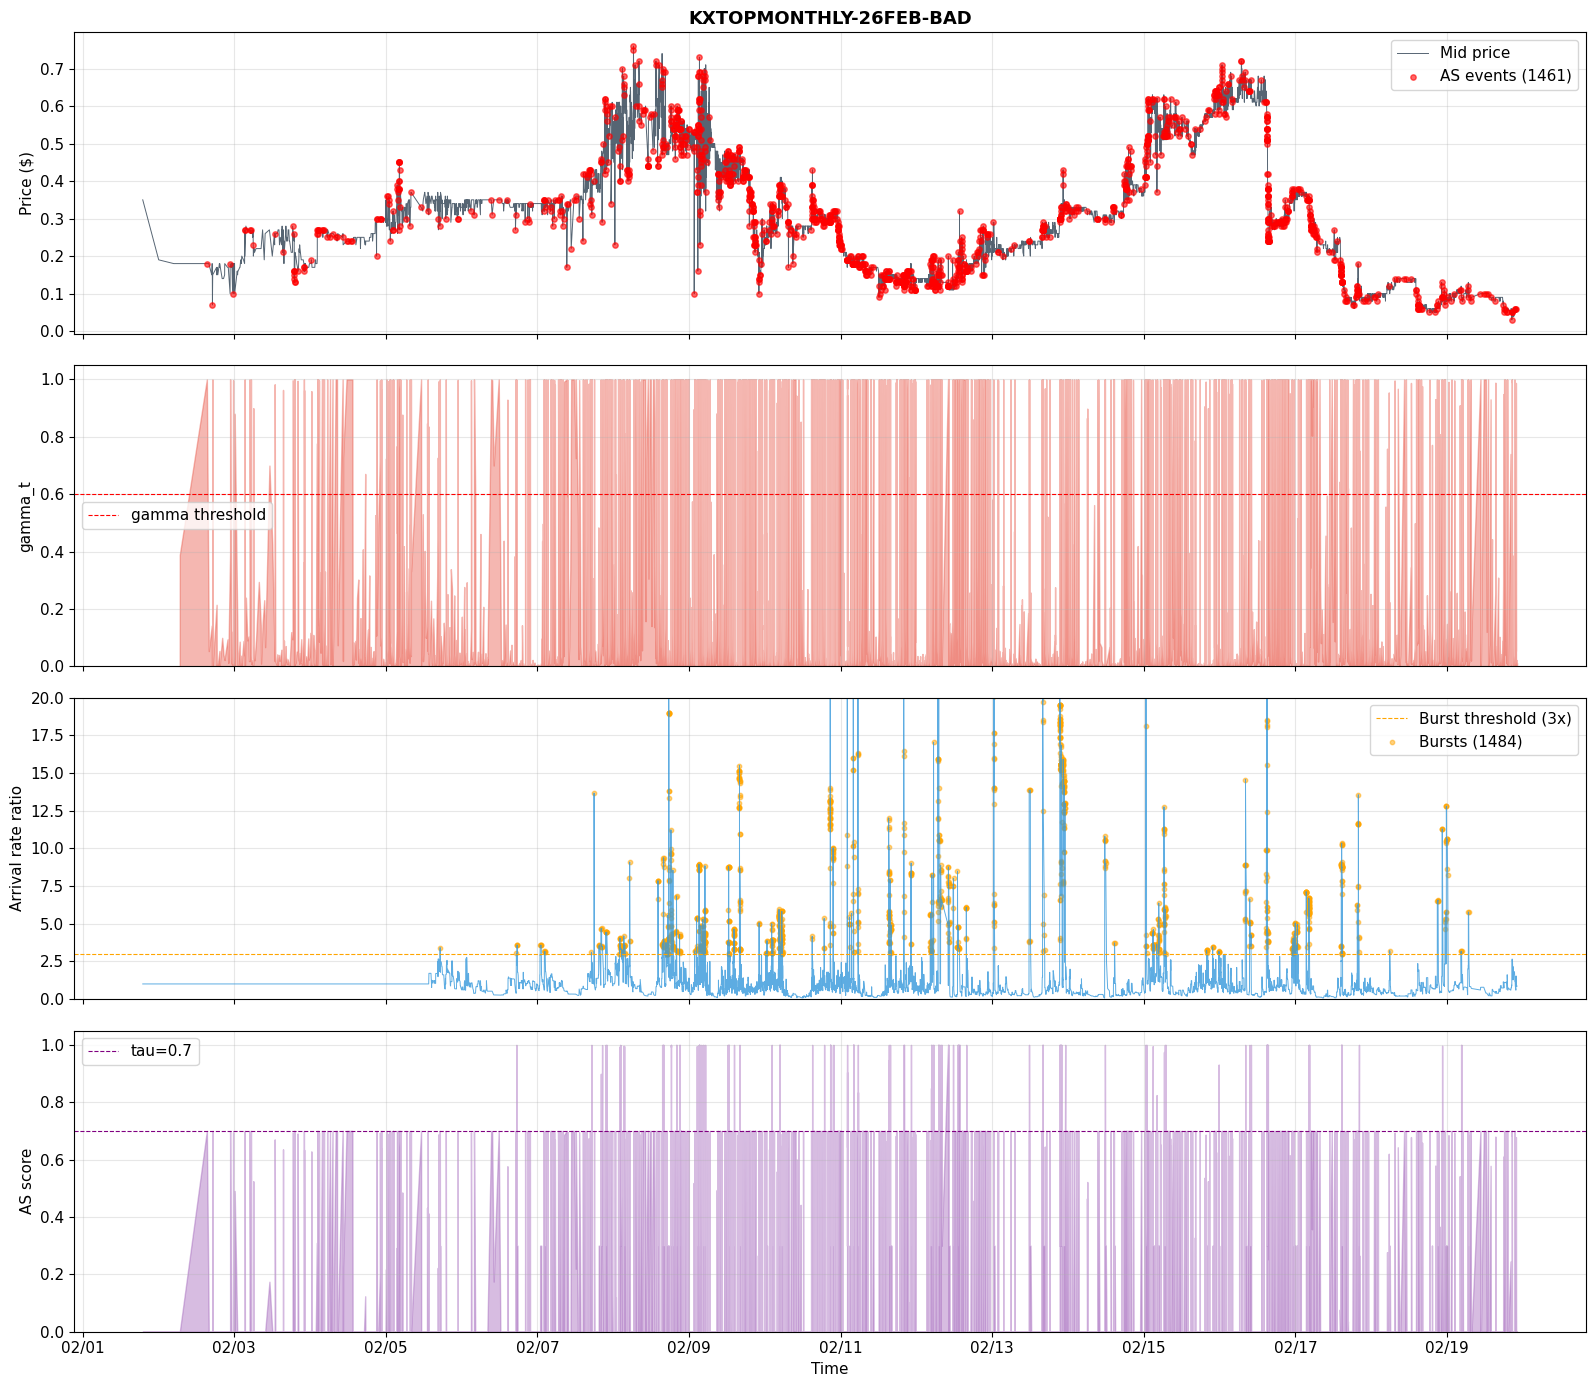

In [13]:
showcase_tkr = max(all_as.keys(), key=lambda k: len(all_as[k].prices))
ar = all_as[showcase_tkr]
print(f"Showcase: {showcase_tkr} ({len(ar.prices):,} trades)")

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)
ts = pd.to_datetime(ar.timestamps)

axes[0].plot(ts, ar.prices, color="#2c3e50", lw=0.7, alpha=0.8, label="Mid price")
em = ar.as_score > 0.5
axes[0].scatter(ts[em], ar.prices[em], color="red", s=15, alpha=0.6, zorder=5, label=f"AS events ({em.sum()})" )
axes[0].set_ylabel("Price ($)"); axes[0].set_title(f"{showcase_tkr}", fontsize=13, fontweight="bold"); axes[0].legend()

axes[1].fill_between(ts, 0, ar.gamma, color="#e74c3c", alpha=0.4)
axes[1].axhline(0.6, color="red", ls="--", lw=0.8, label="gamma threshold"); axes[1].set_ylabel("gamma_t"); axes[1].set_ylim(0, 1.05); axes[1].legend()

axes[2].plot(ts, ar.arrival_rate_ratio, color="#3498db", lw=0.7, alpha=0.8)
axes[2].axhline(3.0, color="orange", ls="--", lw=0.8, label="Burst threshold (3x)")
if ar.burst_flags.sum() > 0:
    axes[2].scatter(ts[ar.burst_flags], ar.arrival_rate_ratio[ar.burst_flags], color="orange", s=10, alpha=0.5, label=f"Bursts ({ar.burst_flags.sum()})")
axes[2].set_ylabel("Arrival rate ratio"); axes[2].set_ylim(0, min(ar.arrival_rate_ratio.max() * 1.1, 20)); axes[2].legend()

axes[3].fill_between(ts, 0, ar.as_score, color="#9b59b6", alpha=0.4)
axes[3].axhline(0.7, color="purple", ls="--", lw=0.8, label="tau=0.7"); axes[3].set_ylabel("AS score"); axes[3].set_ylim(0, 1.05); axes[3].set_xlabel("Time"); axes[3].legend()

for a in axes: a.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.tight_layout()
os.makedirs("../figures", exist_ok=True)
plt.savefig("../figures/as_detection_showcase.png", dpi=150, bbox_inches="tight")
plt.show()


## 4. Belief-Volatility Surface


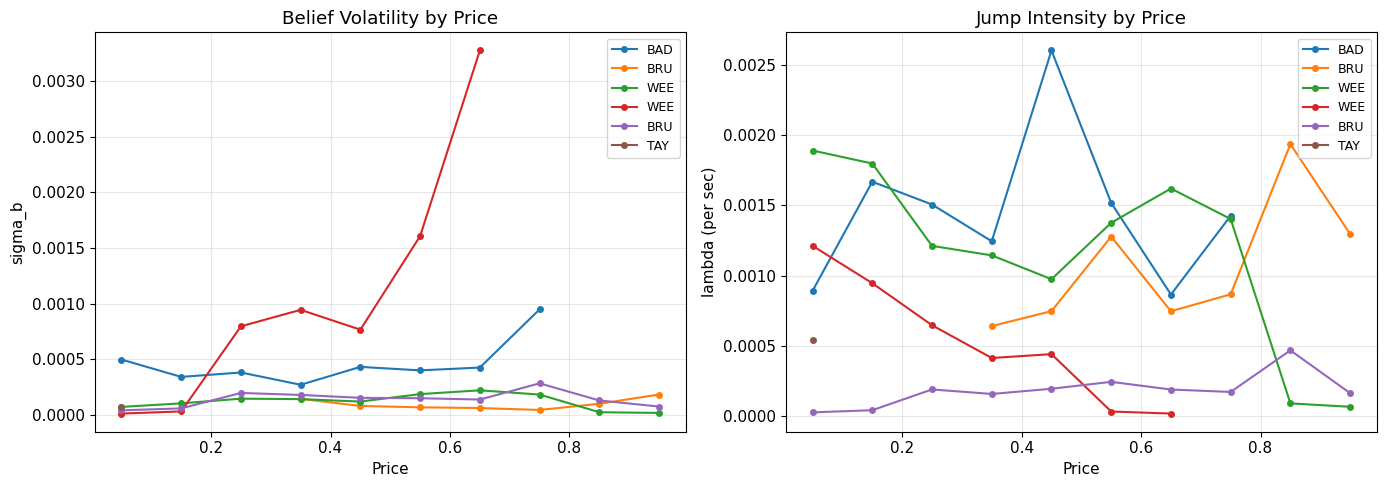

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for tkr in list(all_as.keys())[:6]:
    ar = all_as[tkr]; valid = ~np.isnan(ar.sigma_b_sq)
    if valid.sum() < 50: continue
    p, sv, lv = ar.prices[valid], np.sqrt(ar.sigma_b_sq[valid]), ar.lam[valid]
    bins = np.arange(0, 1.05, 0.1); bi = np.digitize(p, bins) - 1; bc = (bins[:-1]+bins[1:])/2
    sb, lb, vc = [], [], []
    for b in range(len(bc)):
        m = bi == b
        if m.sum() >= 10: sb.append(np.median(sv[m])); lb.append(np.median(lv[m])); vc.append(bc[b])
    sn = tkr.split("-")[-1]
    if vc: axes[0].plot(vc, sb, "o-", label=sn, ms=4); axes[1].plot(vc, lb, "o-", label=sn, ms=4)
axes[0].set_xlabel("Price"); axes[0].set_ylabel("sigma_b"); axes[0].set_title("Belief Volatility by Price"); axes[0].legend(fontsize=9)
axes[1].set_xlabel("Price"); axes[1].set_ylabel("lambda (per sec)"); axes[1].set_title("Jump Intensity by Price"); axes[1].legend(fontsize=9)
plt.tight_layout(); plt.savefig("../figures/belief_vol_surface.png", dpi=150, bbox_inches="tight"); plt.show()


## 5. AS Event Characterisation


Total AS events: 12,153 across 13 tickers


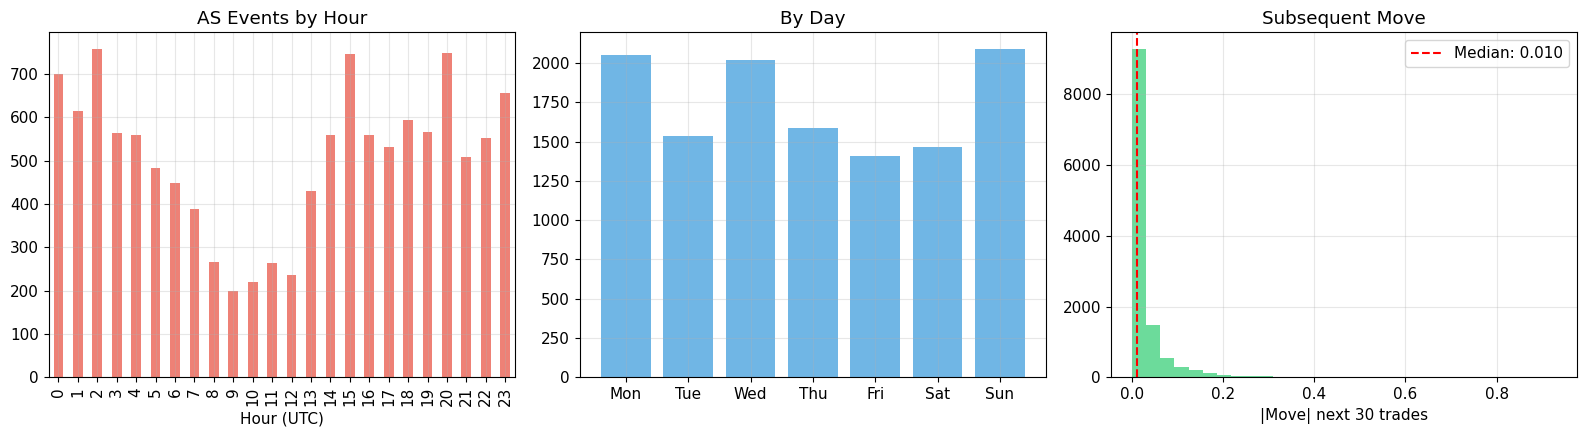

In [16]:
all_events = []
for tkr, ar in all_as.items():
    mask = ar.as_score > 0.5
    if not mask.any(): continue
    ts_ev = pd.to_datetime(ar.timestamps[mask]); indices = np.where(mask)[0]
    fm = [abs(ar.prices[min(i+30, len(ar.prices)-1)] - ar.prices[i]) for i in indices]
    for j, i in enumerate(indices):
        all_events.append({"ticker": tkr, "hour": ts_ev[j].hour, "dow": ts_ev[j].dayofweek,
            "price": ar.prices[mask][j], "gamma": ar.gamma[mask][j], "future_move": fm[j]})
events_df = pd.DataFrame(all_events)
print(f"Total AS events: {len(events_df):,} across {events_df.ticker.nunique()} tickers")

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
events_df["hour"].value_counts().sort_index().plot.bar(ax=axes[0], color="#e74c3c", alpha=0.7)
axes[0].set_xlabel("Hour (UTC)"); axes[0].set_title("AS Events by Hour")
dn = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]; dw = events_df["dow"].value_counts().sort_index()
axes[1].bar([dn[i] for i in dw.index], dw.values, color="#3498db", alpha=0.7); axes[1].set_title("By Day")
events_df["future_move"].hist(bins=30, ax=axes[2], color="#2ecc71", alpha=0.7)
med = events_df["future_move"].median()
axes[2].axvline(med, color="red", ls="--", label=f"Median: {med:.3f}")
axes[2].set_xlabel("|Move| next 30 trades"); axes[2].set_title("Subsequent Move"); axes[2].legend()
plt.tight_layout(); plt.savefig("../figures/as_event_characterisation.png", dpi=150, bbox_inches="tight"); plt.show()


## 6. Fill Toxicity Validation

The critical test: are subsequent price moves significantly larger during flagged periods?
A ratio > 1 with p < 0.05 confirms the detector identifies toxic flow.


In [17]:
print("Table 2: Fill Toxicity -- Flagged vs Unflagged")
print("=" * 100)
for tkr in list(all_as.keys())[:8]:
    ar = all_as[tkr]
    tox = analyse_fill_toxicity(ar, mtm_horizons=[10, 30, 60, 120])
    if tox.empty: continue
    short = tkr.split("KXTOPMONTHLY-")[-1]
    print(f"\n--- {short} ({len(ar.prices):,} trades) ---")
    print(tox.to_string(index=False, float_format="%.4f"))


Table 2: Fill Toxicity -- Flagged vs Unflagged

--- 26FEB-BAD (11,077 trades) ---
 horizon_trades  n_flagged  n_unflagged  mean_move_flagged  mean_move_unflagged  ratio  t_stat  p_value
             10        903         4635             0.0368               0.0235 1.5681 10.4550   0.0000
             30        903         4635             0.0450               0.0292 1.5413 11.2989   0.0000
             60        903         4635             0.0510               0.0369 1.3819  8.5392   0.0000
            120        903         4635             0.0603               0.0493 1.2221  5.3529   0.0000

--- 26FEB-BRU (5,381 trades) ---
 horizon_trades  n_flagged  n_unflagged  mean_move_flagged  mean_move_unflagged  ratio  t_stat  p_value
             10        498         1875             0.0250               0.0276 0.9081 -1.4207   0.9222
             30        498         1875             0.0375               0.0402 0.9314 -1.3095   0.9047
             60        498         1875             

## 7. Market-Making Backtest (tau=0.7)

At tau=0.7 the AS-informed MM pulls quotes only during the highest-conviction events.


In [18]:
comparisons = compare_all_tickers(all_as, as_threshold=0.7, half_spread_cents=2.0, mtm_horizon_trades=60)
comp_rows = [c.summary for c in comparisons.values()]
comp_df = pd.DataFrame(comp_rows).sort_values("naive_pnl_c", ascending=False)
print("Table 3: Naive vs AS-Informed (tau=0.7)")
print("=" * 130)
print(comp_df.to_string(index=False, float_format="%.2f"))
print(f"\nNaive total:    {comp_df.naive_pnl_c.sum():.1f}c ({comp_df.naive_fills.sum()} fills)")
print(f"Informed total: {comp_df.informed_pnl_c.sum():.1f}c ({comp_df.informed_fills.sum()} fills)")
print(f"Improvement:    {comp_df.improvement_c.sum():+.1f}c ({comp_df.fills_avoided.sum()} fills avoided)")
print(f"Tickers improved: {sum(1 for c in comparisons.values() if c.pnl_improvement > 0)}/{len(comparisons)}")


[2026-02-25 00:47:20 UTC] [INFO] tauroi.mm_backtest — Comparison KXTOPMONTHLY-26FEB-BAD: naive=2112.8c (2238 fills) | informed=2136.9c (2183 fills) | improvement=24.1c | avoided=55 toxic fills
[2026-02-25 00:47:20 UTC] [INFO] tauroi.mm_backtest — Comparison KXTOPMONTHLY-26FEB-BRU: naive=691.8c (926 fills) | informed=582.2c (895 fills) | improvement=-109.6c | avoided=31 toxic fills
[2026-02-25 00:47:20 UTC] [INFO] tauroi.mm_backtest — Comparison KXTOPMONTHLY-26JAN-WEE: naive=665.7c (608 fills) | informed=636.6c (514 fills) | improvement=-29.1c | avoided=94 toxic fills
[2026-02-25 00:47:20 UTC] [INFO] tauroi.mm_backtest — Comparison KXTOPMONTHLY-25DEC-WEE: naive=254.9c (628 fills) | informed=254.9c (628 fills) | improvement=0.0c | avoided=0 toxic fills
[2026-02-25 00:47:20 UTC] [INFO] tauroi.mm_backtest — Comparison KXTOPMONTHLY-26JAN-BRU: naive=-36.2c (286 fills) | informed=-41.1c (285 fills) | improvement=-4.9c | avoided=1 toxic fills
[2026-02-25 00:47:20 UTC] [INFO] tauroi.mm_backtest

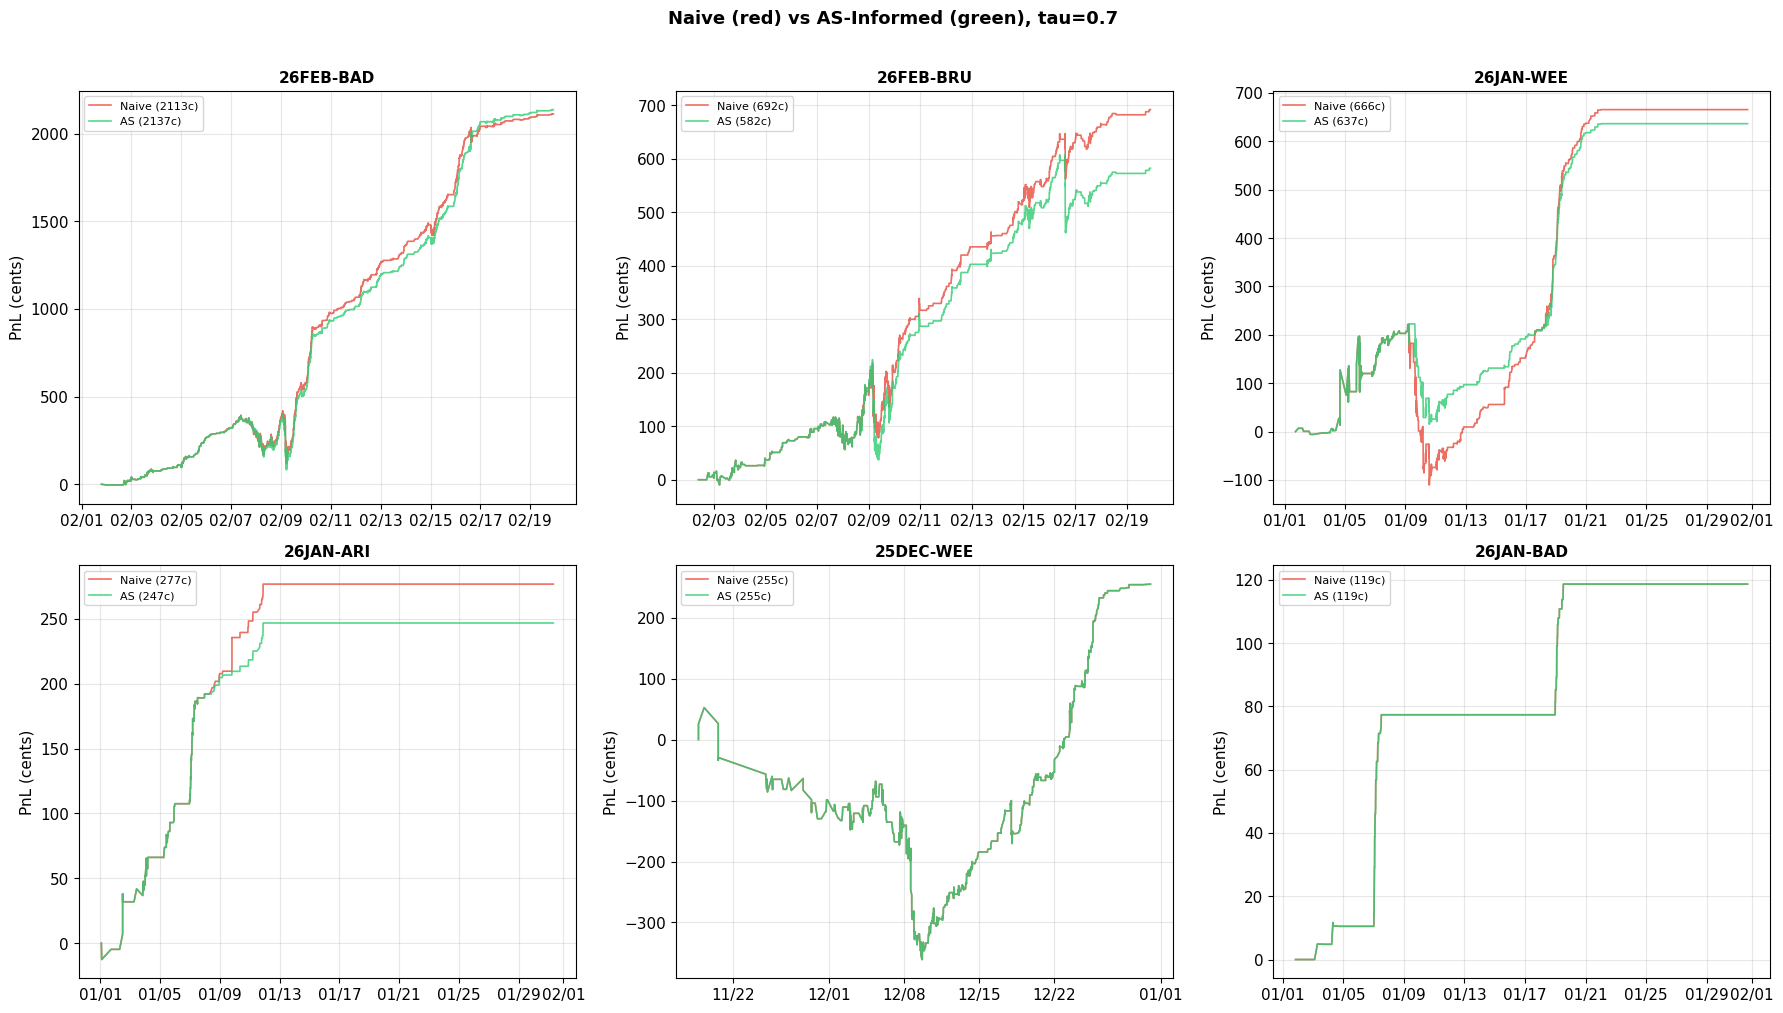

In [19]:
top_tickers = comp_df.head(6)["ticker"].tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for idx, tkr in enumerate(top_tickers):
    if tkr not in comparisons: continue
    ax = axes[idx // 3][idx % 3]; comp = comparisons[tkr]; ar = all_as[tkr]
    tp = pd.to_datetime(ar.timestamps)
    ax.plot(tp, comp.naive.cumulative_pnl, color="#e74c3c", lw=1.2, label=f"Naive ({comp.naive.net_pnl:.0f}c)", alpha=0.8)
    ax.plot(tp, comp.informed.cumulative_pnl, color="#2ecc71", lw=1.2, label=f"AS ({comp.informed.net_pnl:.0f}c)", alpha=0.8)
    ax.set_title(tkr.split("KXTOPMONTHLY-")[-1], fontsize=11, fontweight="bold")
    ax.set_ylabel("PnL (cents)"); ax.legend(fontsize=8); ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.suptitle("Naive (red) vs AS-Informed (green), tau=0.7", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout(); plt.savefig("../figures/mm_pnl_comparison.png", dpi=150, bbox_inches="tight"); plt.show()


## 8. Threshold Sweep


Threshold sweep: KXTOPMONTHLY-26FEB-BAD
 threshold    strategy  n_fills  n_pulled  net_pnl_c  pnl_per_fill_c  win_rate  gross_spread_c  mtm_pnl_c  fees_c
      0.00       naive     2238         0    2112.76            0.94      0.63         4476.00   -1496.00  867.24
      0.10 as_informed     1529      2808     973.05            0.64      0.62         3058.00   -1485.00  599.95
      0.20 as_informed     1536      2789    1014.53            0.66      0.62         3072.00   -1455.00  602.47
      0.30 as_informed     1549      2757    1006.90            0.65      0.62         3098.00   -1484.00  607.10
      0.40 as_informed     1751      1496    1217.23            0.70      0.62         3502.00   -1599.00  685.77
      0.50 as_informed     1765      1461    1219.99            0.69      0.62         3530.00   -1619.00  691.01
      0.60 as_informed     1783      1401    1259.06            0.71      0.62         3566.00   -1609.00  697.94
      0.70 as_informed     2183       233    213

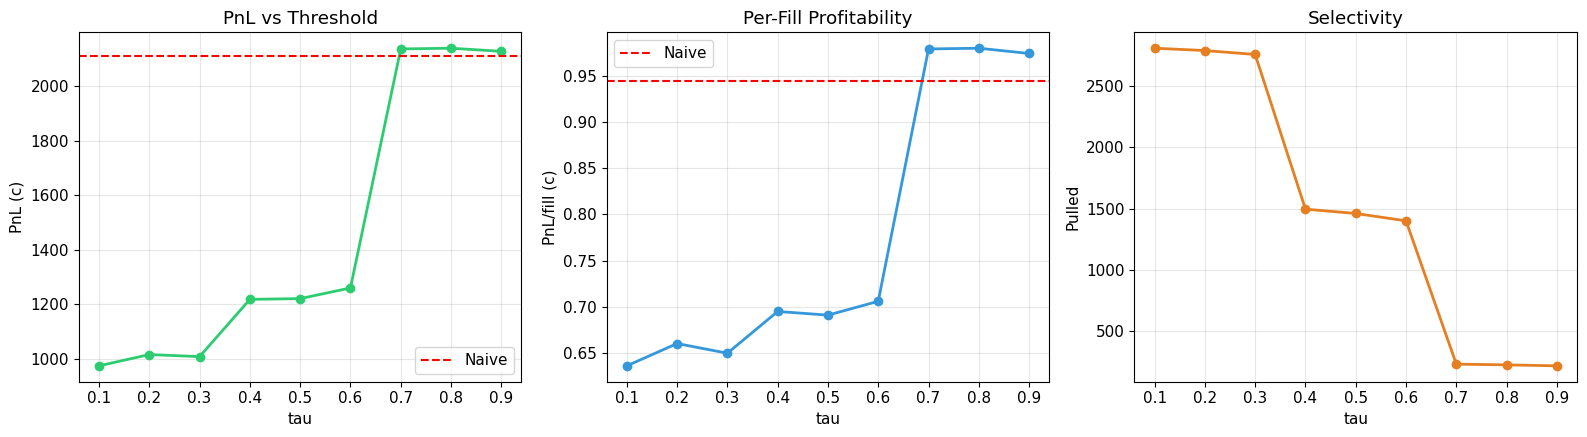

In [20]:
sweep_tkr = max(all_as.keys(), key=lambda k: len(all_as[k].prices))
sweep_df = sweep_thresholds(all_as[sweep_tkr], mtm_horizon_trades=60)
print(f"Threshold sweep: {sweep_tkr}"); print(sweep_df.to_string(index=False, float_format="%.2f"))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
inf = sweep_df[sweep_df.strategy == "as_informed"]
axes[0].plot(inf.threshold, inf.net_pnl_c, "o-", color="#2ecc71", lw=2)
axes[0].axhline(sweep_df.iloc[0].net_pnl_c, color="red", ls="--", label="Naive"); axes[0].set_xlabel("tau"); axes[0].set_ylabel("PnL (c)"); axes[0].set_title("PnL vs Threshold"); axes[0].legend()
axes[1].plot(inf.threshold, inf.pnl_per_fill_c, "o-", color="#3498db", lw=2)
axes[1].axhline(sweep_df.iloc[0].pnl_per_fill_c, color="red", ls="--", label="Naive"); axes[1].set_xlabel("tau"); axes[1].set_ylabel("PnL/fill (c)"); axes[1].set_title("Per-Fill Profitability"); axes[1].legend()
axes[2].plot(inf.threshold, inf.n_pulled, "o-", color="#e67e22", lw=2); axes[2].set_xlabel("tau"); axes[2].set_ylabel("Pulled"); axes[2].set_title("Selectivity")
plt.tight_layout(); plt.savefig("../figures/threshold_sweep.png", dpi=150, bbox_inches="tight"); plt.show()


## 9. Cross-Ticker Jump Propagation


In [21]:
feb_as = {k: v for k, v in all_as.items() if "26FEB" in k}
if len(feb_as) >= 2:
    g5 = {}
    for tkr, ar in feb_as.items():
        g5[tkr.split("-")[-1]] = pd.Series(ar.gamma, index=pd.to_datetime(ar.timestamps)).resample("5min").max().dropna()
    ga = pd.DataFrame(g5).dropna(thresh=2)
    print(f"Co-jump analysis: {len(ga)} 5-min windows")
    print("\nCross-correlation of gamma (5-min max):"); print(ga.corr().round(3).to_string())
    print("\nCo-jump rates (gamma > 0.5 in both):")
    cols = list(ga.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            a, b = cols[i], cols[j]
            both = ((ga[a]>0.5) & (ga[b]>0.5)).sum(); an = (ga[a]>0.5).sum(); bn = (ga[b]>0.5).sum()
            if an > 0 and bn > 0: print(f"  {a}-{b}: {both} co-jumps | P(B|A)={both/an:.1%} | P(A|B)={both/bn:.1%}")


Co-jump analysis: 1994 5-min windows

Cross-correlation of gamma (5-min max):
       BAD    BRU    TAY    WEE
BAD  1.000  0.144  0.194  0.190
BRU  0.144  1.000  0.375  0.359
TAY  0.194  0.375  1.000  0.571
WEE  0.190  0.359  0.571  1.000

Co-jump rates (gamma > 0.5 in both):
  BAD-BRU: 268 co-jumps | P(B|A)=40.7% | P(A|B)=41.4%
  BAD-TAY: 133 co-jumps | P(B|A)=20.2% | P(A|B)=52.6%
  BAD-WEE: 137 co-jumps | P(B|A)=20.8% | P(A|B)=51.3%
  BRU-TAY: 131 co-jumps | P(B|A)=20.2% | P(A|B)=51.8%
  BRU-WEE: 132 co-jumps | P(B|A)=20.4% | P(A|B)=49.4%
  TAY-WEE: 117 co-jumps | P(B|A)=46.2% | P(A|B)=43.8%


## 10. Summary


In [22]:
print("=" * 80); print("ADVERSE SELECTION DETECTION -- SUMMARY"); print("=" * 80)
tt = sum(len(ar.prices) for ar in all_as.values())
te = sum((ar.as_score > 0.5).sum() for ar in all_as.values())
tj = sum((ar.gamma > 0.5).sum() for ar in all_as.values())
tb = sum(ar.burst_flags.sum() for ar in all_as.values())
print(f"\nTickers: {len(all_as)}  |  Trades: {tt:,}  |  AS events: {te:,} ({te/tt*100:.1f}%)")
print(f"Jumps (gamma>0.5): {tj:,}  |  Bursts: {tb:,}")
ms = np.mean([ar.calibration_summary["mean_sigma_b"] for ar in all_as.values()])
ml = np.mean([ar.calibration_summary["mean_lambda"] for ar in all_as.values()])
mj = np.mean([ar.calibration_summary["mean_s_j"] for ar in all_as.values()])
print(f"\nCalibration: sigma_b={ms:.5f}  lambda={ml:.6f}/sec  s_J={mj:.5f}")
nt = sum(c.naive.net_pnl for c in comparisons.values())
it = sum(c.informed.net_pnl for c in comparisons.values())
print(f"\nBacktest (tau=0.7): Naive={nt:.1f}c  Informed={it:.1f}c  Delta={it-nt:+.1f}c")
print(f"Improved: {sum(1 for c in comparisons.values() if c.pnl_improvement > 0)}/{len(comparisons)} tickers")
tox = analyse_fill_toxicity(all_as[max(all_as.keys(), key=lambda k: len(all_as[k].prices))])
if not tox.empty: r = tox.iloc[0]; print(f"\nToxicity: flagged={r.ratio:.2f}x larger moves (t={r.t_stat:.1f}, p={r.p_value:.4f})")
print("=" * 80)


ADVERSE SELECTION DETECTION -- SUMMARY

Tickers: 13  |  Trades: 33,576  |  AS events: 12,153 (36.2%)
Jumps (gamma>0.5): 12,703  |  Bursts: 5,960

Calibration: sigma_b=0.00308  lambda=0.000839/sec  s_J=0.17906

Backtest (tau=0.7): Naive=4302.6c  Informed=4114.0c  Delta=-188.6c
Improved: 1/13 tickers

Toxicity: flagged=1.57x larger moves (t=10.5, p=0.0000)
